# Geometry-adapted fast random walk (GAFRW) algorithm
## Yilin YE @ Avr. 2023

In [353]:
##### Diffusion in Koch-like boundary @ YYE
##### April 2023
##### Generate Koch triangle with arbitraty angles
##### Diffusion and contact PDF.

import numpy as np
import matplotlib.pyplot as plt
import math, random
from itertools import cycle
import copy


### [0]
**Define functions to generate Koch-like polygon's coordinates**

In [129]:
def koch_line(start, end, alpha, direction):
    """
    Segments a line to Koch line, creating fractals.
    :param tuple start:  (x, y) coordinates of the starting point
    :param tuple end: (x, y) coordinates of the end point
    :alpha: angle for Koch triangle (unit: rad)
    :direction: 凹(+1)凸(-1), concave or convex?
    ~returns tuple: tuple of three points between the segmentation
    """
    
    x1, y1 = start[0], start[1] # coordinates of the start
    x2, y2 = end[0], end[1]     # coordinates of the end
    
    # the length of the line
    deltax, deltay = x2 - x1, y2 - y1
    l = np.sqrt((deltax)**2 + (deltay)**2)
    coef = np.sqrt( 2 * (1 - np.cos(alpha)) ) + 2
    segm = l / (coef)
    #dist = segm * coef
    beta = (np.pi - alpha)/2
    if x1==x2:
        if y1<y2:
            theta = + np.pi / 2
        if y1>y2:
            theta = - np.pi / 2
    else:
        theta = np.arctan((deltay)/(deltax))
    if x1>x2:
        theta += np.pi
    
    changex, changey = (deltax)/(coef), (deltay)/(coef)
    # second point: one third in each direction from the first point
    b = (x1+changex, y1+changey)
    # third point: rotation for multiple of 60 degrees
    degree = theta + beta * direction
    c = (b[0] + segm * np.cos(degree), b[1] + segm * np.sin(degree))
    # fourth point: two thirds in each direction from the first point
    d = (x2-changex, y2-changey)
    
    return [b, c, d]





def Koch_generate(polygon, edge, angle, concave, generation):
    
    ## General initial coordinates
    initial_shape = polygon # 3 = triangle, 4 = square, 5 = star, etc.
    edge_length = edge # Initial edge length
    angle_ini = 2.0 * np.pi / initial_shape
    coordinate = []
    #new_x, new_y = 0, 0
    ## Move the polygon center as (0,0)
    tta = np.pi * (1 - 2/polygon)
    new_x, new_y = - edge_length/2, - edge_length/2 * np.tan(tta/2)

    for i in range(initial_shape):
        coordinate.append((new_x,new_y))
        new_x += edge_length * np.cos(i * angle_ini)
        new_y += edge_length * np.sin(i * angle_ini)
    coordinate.append(coordinate[0]) # To form a circle.

    
    max_degree = generation # Define the recursion order
    degre = angle # Define the fractal angle
    direction = concave # Define 凹(concave +1) 凸(convex -1)
    for i in range(max_degree): ## Recursion Order
        num_edge = len(coordinate)
        for j in range(num_edge-1): ## How many times to insert new points?
            num_point = j * 4
            coordinate = coordinate[:num_point+1] + koch_line(coordinate[num_point],coordinate[num_point+1],degre,direction) + coordinate[num_point+1:]

    return coordinate

### [0]
**Define ``distance`` function to furnish the distance between a particle and a segment**

In [130]:
def distance(start,end,particle):
    x1, y1 = start[0], start[1] # coordinates of the start
    x2, y2 = end[0], end[1] # coordinates of the end

    deltax, deltay = x2 - x1, y2 - y1
    ell = np.sqrt(deltax**2 + deltay**2)
    eps = ell / 10**3
    
    if x1 == x2:
        if y1 <= y2:
            theta = + np.pi / 2
        else:
            theta = - np.pi / 2
    else:
        theta = np.arctan(deltay/deltax)
    if x1 > x2:
        theta += np.pi
    st, ct = np.sin(theta), np.cos(theta)
    
    x0, y0 = particle[0], particle[1] # particle's coordiante
    xdist, ydist = x0 - x1, y0 - y1
    dxnew = + ct * xdist + st * ydist #xnew = x1 + ct * xdist + st * ydist
    dynew = - st * xdist + ct * ydist     #ynew = y1 - st * xdist + ct * ydist
    
    if dynew < 0: # To avoid errors while g>2. 或出现某点距离某边负距离，未抵达边界便停止扩散。
        dmin = Length
        dehors = - 1
    else:
        if (dxnew >= 0) and (dxnew <= ell):
            dehors = + 1
            dmin = dynew
            if (dmin < eps):
                dmin = 0.0
        else:
            dehors = 0 
            d1 = np.sqrt(xdist**2 + ydist**2)
            d2 = np.sqrt((x0-x2)**2 + (y0-y2)**2)
            if d1 <= d2:
                dehors, dmin = 1, d1
            else:
                dehors, dmin = 2, d2
        
    return dehors, dmin

### [0]
**Define functions to update intervals ranges.**

In [131]:
## Compute the distance between 2 points
def span(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

## Update the interval range @ given level.
def vertex_update(valeur, arg, min1, min2, argmin1, argmin2):
    if (min1 > min2):
        minint = min1
        min1 = min2
        min2 = minint
        argint = argmin1
        argmin1 = argmin2
        argmin2 = argint

    if (valeur < min1):
        min2 = min1
        argmin2 = argmin1
        min1 = valeur
        argmin1 = arg
    else:
        if (valeur < min2):
            min2 = valeur
            argmin2 = arg

    return min1, min2, argmin1, argmin2

## Make sure the interval in right order.
def petitavant(v1,v2):
    if (v1>v2):
        vint = v1
        v1 = v2
        v2 = vint
    return v1,v2



---
---
---
Below for particule loop!

### [0.0]
**Define Parameters**

In [512]:
%%time
### Initialization
polygon_shape = 3 
Generation_max = 2
num_particle = 1
Length = 1.0e3
alpha_angle_ratio = 3
direction = - 1
pi = 4.0*np.arctan(1.0)
twopi=2.0*pi


### Parameters
num_points = polygon_shape * 4**Generation_max + 1
position = np.zeros((num_particle,2))
coord_x = np.zeros(num_points)
coord_y = np.zeros(num_points)
account = np.zeros(num_points-1)
### Generate trajs
traj = []
for i in range(num_particle):
    traj.append([])
for i in range(num_particle):
    traj[i].append((position[i,0], position[i,1]))


angle_ini = twopi / polygon_shape
tta = pi * (1.0 - 2.0/polygon_shape) 
    
    
coordinate = Koch_generate(3,Length,np.pi/3,-1,Generation_max)
# Extract all coordinates
for i in range(len(coordinate)):
    coord_x[i] = coordinate[i][0]
    coord_y[i] = coordinate[i][1]

CPU times: user 786 µs, sys: 127 µs, total: 913 µs
Wall time: 839 µs


### [：0]
**Show FIGURE!**

<function matplotlib.pyplot.show(*args, **kw)>

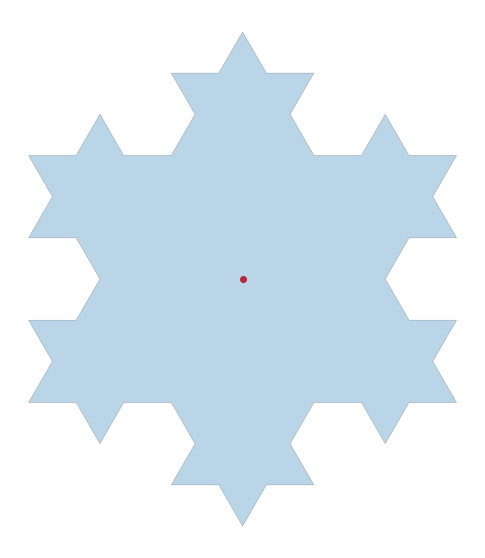

In [513]:
# fill the polygons
plt.figure(figsize=(10,10))
plt.fill(coord_x, coord_y, edgecolor='black', lw=0.5, alpha = 0.3)
plt.scatter(position[:,0],position[:,1],color='red')
plt.axis('off')
plt.axis('scaled')
plt.show

### [1.0]
**Initialize interval range records**

In ``rec[a,b]``, `a` refers to **Generation level**, `b` refers to **Start/End Point**.

``rec_index`` records coordinates indices; ``rec_dist`` records distance between the *i*-the particle and the corresponding coordinate point.

In [514]:
## Add for i in range(num_particle):
i = 0
rec_dist = np.zeros((Generation_max+2,2))
## Note rec_index should be integer.
rec_index = [[0,0] for i in range(Generation_max+2)]
## Initialize all points in each level as max range.
for j in range(Generation_max+2):
    rec_index[j][1] = num_points - 1
    
#rec_dist[:][:] = Length
## 放弃严格逐个求距离，扩散过程中可能同时远离两点仅靠近一点，若按上述标准：则永远保持初始距离不变，影响后续判断

## 以下仍严格计算距离，注意每次扩散移动后更新新距离。

In [515]:
for j in range(Generation_max+2):
    rec_dist[j,0] = span(coord_x[rec_index[j][0]],coord_y[rec_index[j][0]],position[i,0],position[i,1])
    rec_dist[j,1] = span(coord_x[rec_index[j][1]],coord_y[rec_index[j][1]],position[i,0],position[i,1])    
    
print(rec_index)
print(rec_dist)

[[0, 48], [0, 48], [0, 48], [0, 48]]
[[577.35026919 577.35026919]
 [577.35026919 577.35026919]
 [577.35026919 577.35026919]
 [577.35026919 577.35026919]]


1. Determine interval range by coordinate index; ``rec_index[g_last]``
2. Find 2 nearest points in this range @ next level; ``rec_index[g_act]``
3. Determine the diffusion radius in new interval; ``rec_index[g_act]``
4. Determine if cross the boundary; ``rec_index[g_test]`` = min @ ``rec_index[g_test-1]`` for all ``g_test <= g_act``

### [1.1]
**Initialize `g_last` & `g_act`** (for start-up)

In [516]:
### At first, direct diffusion needed. w/o finding 2 nearest points
g_act = 1
g_last = 0

int_gap = 4**(Generation_max - g_act + 1)

### Then goto[3]

### [1.2]
**Initialize `g_last` & `g_act`** (not for start-up)

In [807]:
print(rec_index)
print(rec_dist)

[[0, 48], [32, 48], [32, 36], [34, 35]]
[[817.30256909 817.30256909]
 [195.93429294 817.30256909]
 [195.93429294 161.34571275]
 [ 37.21706625  73.89418362]]


In [808]:
## If all check valid?
#g_last = g_act
#g_act += 1
if g_last < Generation_max+1:
    g_last += 1
else:
    g_last = Generation_max+1


int_gap = 4**(Generation_max - g_last + 1)
print(g_last,g_act,int_gap)

3 2 1


In [809]:
Generation_max, g_last

(2, 3)

### [2]
**Find 2 nearest points** (not for start-up)

In [810]:
## Update rec_dist
#rec_dist[g_last][0] = span(coord_x[rec_index[g_last][0]],coord_y[rec_index[g_last][0]],position[i,0],position[i,1])
#rec_dist[g_last][1] = span(coord_x[rec_index[g_last][1]],coord_y[rec_index[g_last][1]],position[i,0],position[i,1])

## 搜索前直接固定要搜索的级别边界条件等于上一级，然后只搜索边界内新生成点。
## 由此避免初期任意赋值长度，导致循环过程中坐标序号与长度不匹配！
## 如rec_dist=[1000,1000],rec_index[0,48]，新加入点36距离100，更新后变成
## rec_dist = [100,1000],rec_index[0,36]；然而36对应100而非1000。
rec_dist[g_last] = copy.deepcopy( rec_dist[g_last - 1] )
rec_index[g_last]= copy.deepcopy( rec_index[g_last- 1] )
## 如此，搜索时要避开上一级端点，以免重复考虑仅有一点重复纳入记录。
### 放弃直接操作rec数组，直接搜索最小两点后再赋值。


l1, l2 = rec_dist[g_last - 1][0], rec_dist[g_last - 1][1] #Length, Length, 0, 0
k1, k2 =rec_index[g_last - 1][0],rec_index[g_last - 1][1]
if l1>l2:
    lint = l1
    l1 = l2
    l2 = lint
    kint = k1
    k1 = k2
    k2 = kint

if g_last == 1:
    supvl = rec_index[g_last-1][1]
else:
    supvl = rec_index[g_last-1][1] #+ 1


if g_last==1:
    #rec_dist[g_last][1] = Length
    for j in range(rec_index[g_last-1][0] + int_gap, supvl, int_gap): ## 注意首轮不考虑最后一点！
        u = span(coord_x[j],coord_y[j],position[i,0],position[i,1])
        print("g_last=",g_last,u,j)
        #rec_dist[g_last][0], rec_dist[g_last][1], rec_index[g_last][0], rec_index[g_last][1] = vertex_update(u,j,rec_dist[g_last][0], rec_dist[g_last][1], rec_index[g_last][0], rec_index[g_last][1])
        ## Make sure small value in front of larger one.
        #rec_index[g_last][0], rec_index[g_last][1] = petitavant(rec_index[g_last][0], rec_index[g_last][1])
        
        
        ## vertex_update总有问题，将计算所得 插入 已知结果，必然只能得到最小值重复两次
        ## 应考虑直接循环找到最小两点，之后再给rec_index/dist赋值
        if (u<l1)and(u<l2):
            l2, k2 = l1, k1
            l1, k1 = u, j
            print("YES!!")
        else:
            if (u<l2):
                l2, k2 = u, j
                print("YES")
        print(l1, l2, k1, k2)
    rec_index[g_last][0], rec_index[g_last][1] = petitavant(k1, k2)
        
    print(rec_index)
    print(rec_dist)
    
    ## To avoid the confusion for last segment selected. 
    ## 1/n 概率，首轮扩散靠近最后一条边。由于首位相接，这时g=1对应最近两点仍为首尾；故增补以下判断
    if (np.abs(rec_index[g_last][1] - rec_index[g_last][0]) > int_gap):
        rec_index[g_last][0] = rec_index[g_last - 1][1] - int_gap
        rec_index[g_last][1] = rec_index[g_last - 1][1]
else:
    for j in range(rec_index[g_last-1][0] + int_gap, supvl, int_gap):
        u = span(coord_x[j],coord_y[j],position[i,0],position[i,1])
        print("g_last=",g_last,u,j)
        #rec_dist[g_last][0], rec_dist[g_last][1], rec_index[g_last][0], rec_index[g_last][1] = vertex_update(u,j,rec_dist[g_last][0], rec_dist[g_last][1], rec_index[g_last][0], rec_index[g_last][1])
        #rec_index[g_last][0], rec_index[g_last][1] = petitavant(rec_index[g_last][0], rec_index[g_last][1])

        if (u<l1)and(u<l2):
            l2, k2 = l1, k1
            l1, k1 = u, j
        else:
            if (u<l2):
                l2, k2 = u, j
    rec_index[g_last][0], rec_index[g_last][1] = petitavant(k1, k2)
    
for j in range(Generation_max+2):
    rec_dist[j,0] = span(coord_x[rec_index[j][0]],coord_y[rec_index[j][0]],position[i,0],position[i,1])
    rec_dist[j,1] = span(coord_x[rec_index[j][1]],coord_y[rec_index[j][1]],position[i,0],position[i,1])    


    
print(rec_index)
print(rec_dist)

g_last= 3 97.87553192145707 33
g_last= 3 37.21706624636118 34
g_last= 3 73.89418362295689 35
[[0, 48], [32, 48], [32, 36], [34, 35]]
[[817.30256909 817.30256909]
 [195.93429294 817.30256909]
 [195.93429294 161.34571275]
 [ 37.21706625  73.89418362]]


In [811]:
rec_dist[g_last - 1][0], rec_dist[g_last - 1][1]

(195.93429293823078, 161.3457127487116)

In [812]:
#rec_dist[g_last] = rec_dist[g_last - 1]
#rec_index[g_last]= rec_index[g_last- 1]


print(rec_index)
print(rec_dist)

[[0, 48], [32, 48], [32, 36], [34, 35]]
[[817.30256909 817.30256909]
 [195.93429294 817.30256909]
 [195.93429294 161.34571275]
 [ 37.21706625  73.89418362]]


### [3] 
**Determine diffusion radius** (able for start-up)

In [813]:
radius_min = Length
for j in range(rec_index[g_last][0], rec_index[g_last][1], int_gap):
    l = j + int_gap
    case, radius = distance([coord_x[j],coord_y[j]], [coord_x[l],coord_y[l]], position[i])
    if case!=-1:
        if radius_min>radius:
            radius_min = radius
            k = j
print("g_last",g_last,k, radius_min)

g_last 3 34 0.0


In [814]:
print(rec_index)
print(rec_dist)

[[0, 48], [32, 48], [32, 36], [34, 35]]
[[817.30256909 817.30256909]
 [195.93429294 817.30256909]
 [195.93429294 161.34571275]
 [ 37.21706625  73.89418362]]


### [4]
**Diffusion** with given `radius_min`.

In [815]:
if (radius_min>0):
    random_angle = random.uniform(0,2*np.pi)
    move_x = radius_min * np.cos(random_angle)
    move_y = radius_min * np.sin(random_angle)
    position[i,0] += move_x
    position[i,1] += move_y
    traj[i].append((position[i,0], position[i,1]))
else:
    if (g_last == Generation_max+1):
        account[k] += 1
        #break # Jump out of while loop
    else:
        g_last += 1
        #g_last = g_act
        #g_act += 1
        
print(position[i])

## Update rec_dist
#rec_dist[g_last][0] = span(coord_x[rec_index[g_last][0]],coord_y[rec_index[g_last][0]],position[i,0],position[i,1])
#rec_dist[g_last][1] = span(coord_x[rec_index[g_last][1]],coord_y[rec_index[g_last][1]],position[i,0],position[i,1])
for j in range(Generation_max+2):
    rec_dist[j,0] = span(coord_x[rec_index[j][0]],coord_y[rec_index[j][0]],position[i,0],position[i,1])
    rec_dist[j,1] = span(coord_x[rec_index[j][1]],coord_y[rec_index[j][1]],position[i,0],position[i,1])    


[-147.98640489  448.93581861]


In [816]:
traj

[[(0.0, 0.0),
  (44.6204359360299, 285.20580293923194),
  (0.7204099619478015, 383.25655558144854),
  (-74.0998165505653, 444.07860413369235),
  (-71.87106978246376, 445.1281584845067),
  (-47.329446861812826, 418.79381790945246),
  (-102.81436816668736, 448.3623247661479),
  (-122.01437047580364, 421.8148672831245),
  (-116.07193508518682, 428.5938701377293),
  (-128.62319403080295, 440.861350125618),
  (-135.6397265880455, 451.58441911497687),
  (-135.80575444785194, 463.6829956795914),
  (-146.95004881336803, 450.265244630978),
  (-147.79616147132973, 448.85441003428423),
  (-147.9864048912605, 448.93581861429436)]]

In [817]:
print(rec_index)
print(rec_dist)

[[0, 48], [32, 48], [32, 36], [34, 35]]
[[817.30256909 817.30256909]
 [195.93429294 817.30256909]
 [195.93429294 161.34571275]
 [ 37.21706625  73.89418362]]


### [：0]
**Show FIGURE!**

<function matplotlib.pyplot.show(*args, **kw)>

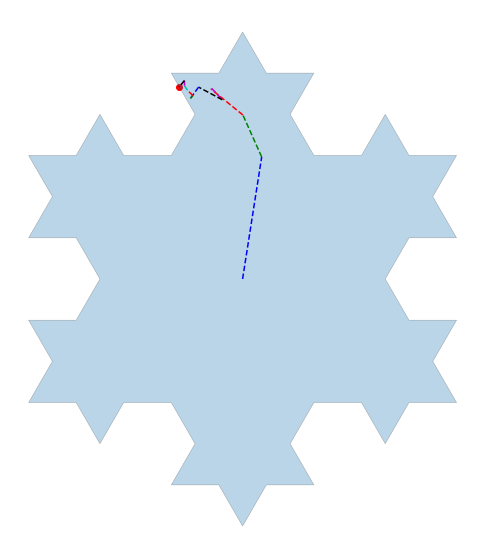

In [818]:
# fill the polygons
plt.figure(figsize=(10,10))
plt.fill(coord_x, coord_y, edgecolor='black', lw=0.5, alpha = 0.3)
plt.scatter(position[:,0],position[:,1],color='red')
cycol = cycle('bgrcmk')
for j in range(len(traj[i])-1):
    random_color = next(cycol)
    plt.plot([traj[i][j][0],traj[i][j+1][0]],[traj[i][j][1],traj[i][j+1][1]],'--',c=random_color)
plt.axis('off')
plt.axis('scaled')
plt.show

In [801]:
for j in range(1,2):
    print(j)
print(g_last)

1
3


In [802]:
for j in range(Generation_max+2):
    rec_dist[j,0] = span(coord_x[rec_index[j][0]],coord_y[rec_index[j][0]],position[i,0],position[i,1])
    rec_dist[j,1] = span(coord_x[rec_index[j][1]],coord_y[rec_index[j][1]],position[i,0],position[i,1])    
    
print(rec_index)
print(rec_dist)

[[0, 48], [32, 48], [32, 36], [34, 35]]
[[817.30256909 817.30256909]
 [195.93429294 817.30256909]
 [195.93429294 161.34571275]
 [ 37.21706625  73.89418362]]


### [5]
**Determine if go out** (not for start up)

In [803]:
for g_test in range(1,g_last+1):
    
    if g_test == 1:
        supvl = rec_index[g_test-1][1]
    else:
        supvl = rec_index[g_test-1][1] #+ 1
        
        
    rec_old1, rec_old2 = rec_index[g_test][0], rec_index[g_test][1]
    int_gap = 4**(Generation_max - g_test + 1)

    #l1, l2, k1, k2 = Length, Length, 0, 0
    l1, l2 = rec_dist[g_test - 1][0], rec_dist[g_test - 1][1]#Length, Length, 0, 0
    k1, k2 =rec_index[g_test - 1][0],rec_index[g_test - 1][1]
    if l1>l2:
        lint = l1
        l1 = l2
        l2 = lint
        kint = k1
        k1 = k2
        k2 = kint


    for j in range(rec_index[g_test-1][0] + int_gap, supvl, int_gap):
        u = span(coord_x[j],coord_y[j],position[i,0],position[i,1])
        print("g_test=",g_test,u,j)
        ## vertex_update总有问题，将计算所得 插入 已知结果，必然只能得到最小值重复两次
        ## 应考虑直接循环找到最小两点，之后再给rec_index/dist赋值
        if (u<l1)and(u<l2):
            l2, k2 = l1, k1
            l1, k1 = u, j
        else:
            if (u<l2):
                l2, k2 = u, j
    ## 目前最小两点为（k1,k2），距离为（l1，l2）
    rec_index[g_test][0], rec_index[g_test][1] = petitavant(k1, k2)
    print(k1,k2)
        
        
        
    if g_test == 1: ## 避免零阶首尾部分报错。
        if (np.abs(rec_index[g_test][1] - rec_index[g_test][0]) > int_gap):
            #rec_index[g_test][0] = rec_index[g_test][1]
            #rec_index[g_test][1] += int_gap
            #u = rec_dist[g_test][0]
            #rec_dist[g_test][0] = rec_dist[g_test][1]
            #rec_dist[g_test][1] = u
            rec_index[g_test][0] = rec_index[g_test - 1][1] - int_gap
            rec_index[g_test][1] = rec_index[g_test - 1][1]
    ## 要求最小两点仍处于原边界限制内，否则回到 g_test 再次计算
    if (rec_old1>rec_index[g_test][0])or(rec_old2<rec_index[g_test][1]):
        #rec_index[g_test][0] = rec_old1
        #rec_index[g_test][1] = rec_old2
        g_last = g_test
        #g_act = g_last + 1
        print("Break @ g_last = ",g_last)
        break
    #else turn to next loop ``g_test += 1``

g_test= 1 981.8127617921598 16
g_test= 1 195.93429293823078 32
32 0
g_test= 2 161.3457127487116 36
g_test= 2 386.77778889663705 40
g_test= 2 485.6921382087602 44
36 32
g_test= 3 97.87553192145707 33
g_test= 3 37.21706624636118 34
g_test= 3 73.89418362295689 35
34 35


In [804]:
print(rec_index)
print(rec_dist)
print(g_last)

[[0, 48], [32, 48], [32, 36], [34, 35]]
[[817.30256909 817.30256909]
 [195.93429294 817.30256909]
 [195.93429294 161.34571275]
 [ 37.21706625  73.89418362]]
3


In [805]:
print(rec_index[g_test][0], rec_index[g_test][1])
print(rec_old1, rec_old2)

34 35
34 35


In [806]:
for j in range(Generation_max+2):
    rec_dist[j,0] = span(coord_x[rec_index[j][0]],coord_y[rec_index[j][0]],position[i,0],position[i,1])
    rec_dist[j,1] = span(coord_x[rec_index[j][1]],coord_y[rec_index[j][1]],position[i,0],position[i,1])    
    
print(rec_index)
print(rec_dist)

[[0, 48], [32, 48], [32, 36], [34, 35]]
[[817.30256909 817.30256909]
 [195.93429294 817.30256909]
 [195.93429294 161.34571275]
 [ 37.21706625  73.89418362]]
